# Using Metadensity in Jupter notebooks
This notebook showcases SF3B4, U2 density around branchpoints

In [1]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/tscc/nfs/home/hsher/Metadensity/config/hg38-tscc2.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
import sys
sys.path.append('/home/hsher/projects/Metadensity/scripts')

plt.style.use('seaborn-white')

please set the right config according to genome coordinate
Using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
Using HG38 by default
Using /tscc/nfs/home/hsher/gencode_coords/GRCh38.p13.genome.fa


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-yo_6ukk6 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Using:  /tscc/nfs/home/hsher/gencode_coords/gencode.v33.transcript.gff3


## load RBPs into eCLIP object
download test data from:
```
wget https://www.dropbox.com/s/cgkeuqr0cjif558/test_data.tar.gz
tar -xvzf test_data.tar.gz
```

In [2]:
from pathlib import Path
test_data_dir = Path('/tscc/nfs/home/hsher/test_data/') # where you downloaded test_data
data_series = pd.Series(
    {'bam_0': str(test_data_dir/'processed_bam/SF3B4_CLIP.r2.bam'),
     'bam_control_0': str(test_data_dir/'processed_bam/SF3B4_INPUT.r2.bam'),
     'minus_0': str(test_data_dir/'coverage/SF3B4_CLIP.minus.bw'),
     'minus_control_0': str(test_data_dir/'coverage/SF3B4_INPUT.minus.bw'),
     'plus_0': str(test_data_dir/'coverage/SF3B4_CLIP.plus.bw'),
     'plus_control_0': str(test_data_dir/'coverage/SF3B4_INPUT.plus.bw'),
     'bed_0': str(test_data_dir/'SF3B4.bed'),
     'uid': 'SF3B4_test',
     'RBP': 'SF3B4'
    })

# index the bams
import pysam
pysam.index(data_series['bam_0'])
pysam.index(data_series['bam_control_0'])

''

In [3]:
SF3B4 = eCLIP.from_series(data_series,
                          single_end = False)

In [4]:
clips = [SF3B4]

# Calculate Density and Truncation sites
Object `Metatruncation` and `Metadensity` takes three things:
1. an experiment object `eCLIP` or `STAMP`.
2. a set of transcript pyBedTools that you want to plot on
3. name of the object

Options include:
1. `sample_no=` allows you to decide how many transcript you want to build the density. It will take longer. By default, `sample_no=200`. So in transcript if you give more than 200 transcripts, only 200 will be used
2. `metagene` allows you to use pre-built metagene. This feature is more useful when you want to compare the same set of RNA over many RBPs.
3. `background_method` handles how you want to deal with IP v.s. Input
4. `normalize` handles how you want to normalize values within a transcript.

## Difference between truncation and density

`Metadensity` represents read coverage. `Metatruncation` represents the 5' end of read 2 for `eCLIP`; edit sites for `STAMP`.

In [5]:
# here for the set of transcript, we use the IDR peak containing transcript assuming they have good signal
def build_idr_metadensity(eCLIP):
    ''' build metadensity object for eCLIP and its idr peak containing transcript'''
    m = Metadensity(eCLIP, eCLIP.name,background_method = 'relative information', normalize = False)
    m.get_density_array()
    return m
def build_idr_metatruncate(eCLIP):
    ''' build metadensity object for eCLIP and its idr peak containing transcript'''
    m = Metatruncate(eCLIP, eCLIP.name,background_method = 'relative information', normalize = False)
    m.get_density_array(use_truncation = True)
    return m

In [6]:
# this step takes some time for building metagene from the annotation files.
den = [build_idr_metadensity(e) for e in clips]
trun = [build_idr_metatruncate(e) for e in clips]

Using: /tscc/nfs/home/hsher/projects/Metadensity/metadensity/data/hg38/gencode
Done building metagene
need at least one array to concatenate
Using: /tscc/nfs/home/hsher/projects/Metadensity/metadensity/data/hg38/gencode
Done building metagene
need at least one array to concatenate


## Visualize RBP map: individual density per transcript

use `feature_to_show` to decide what features to show. 

/opt/Metadensity/metadensity/plotd.py:187: RuntimeWarning: Mean of empty slice
  density_concat = np.nanmean(np.stack([den_arr[feat,align, r] for r in m.eCLIP.rep_keys]), axis = 0)


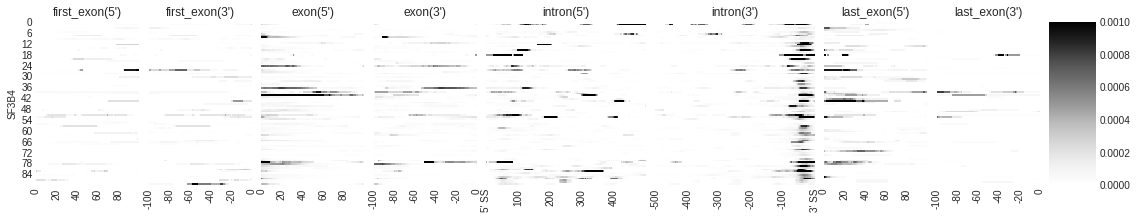

In [7]:
### PLOT INDIVIDUAL DENSITY
# you can customize the list of features you want to show. This is suitable when you are looking for splicing
f = plot_rbp_map(den, features_to_show = generic_rna)

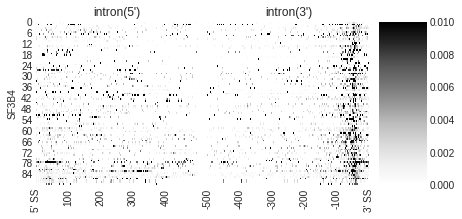

In [8]:
### PLOT INDIVIDUAL TRUNCATION SITES

f = plot_rbp_map(trun, features_to_show = ['intron'], cmap = 'Greys', ymax = 0.01)
f.savefig('SF3B4_rnamap.svg', dpi = 300)

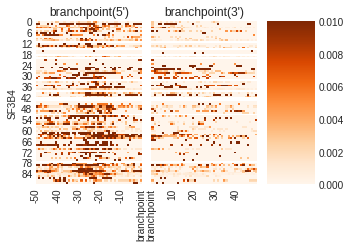

In [9]:
### PLOT INDIVIDUAL TRUNCATION SITES

f = plot_rbp_map(trun, features_to_show = ['branchpoint'], ymax = 0.01, cmap = 'Oranges')
f.savefig('SF3B4_brmap.svg', dpi = 300)

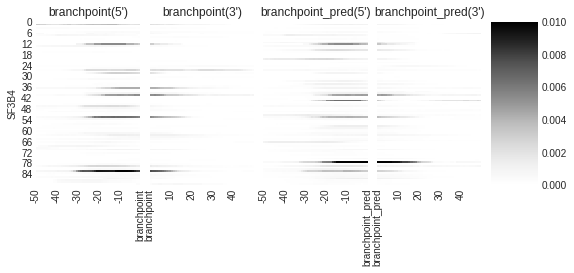

In [10]:
### PLOT INDIVIDUAL DENSITY SITES
f = plot_rbp_map(den, features_to_show = branchpoints, ymax = 0.01)

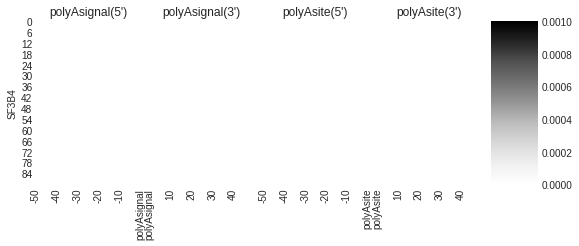

In [11]:
### PLOT INDIVIDUAL TRUNCATION SITES

f = plot_rbp_map(trun, features_to_show = polyAs, ymax = 0.001)

# Median and Mean density

In [12]:
color_dict = {'SF3B4': 'royalblue', 'SF3A3':'mediumorchid', 'U2AF1':'tomato'}

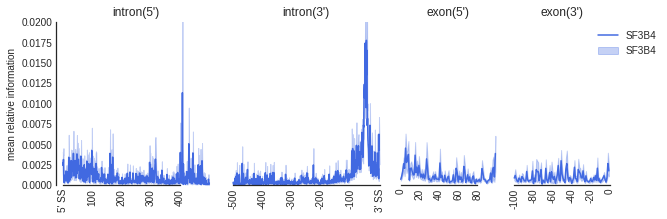

In [13]:
f=plot_mean_density(trun,
                    features_to_show = ['intron', 'exon'], ymax = 0.02,
                   color_dict = color_dict)
f=beautify(f, offset = 0) # sns.despine 
f.get_axes()[0].set_ylabel('mean relative information')
f.savefig('SF3B4_rna.svg', dpi = 300)

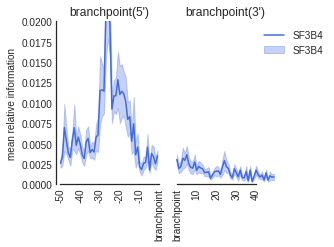

In [14]:

f=plot_mean_density(trun,
                    features_to_show = ['branchpoint'], ymax = 0.02,
                   color_dict = color_dict)
f.get_axes()[0].set_ylabel('mean relative information')
f=beautify(f, offset = 0) # sns.despine 
f.savefig('SF3B4_br.svg', dpi = 300)